In [1]:
from random import random

import matplotx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(matplotx.styles.pitaya_smoothie['light'])
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

from sklearn.ensemble import GradientBoostingClassifier as GBC  # 梯度提升分类树模型
from sklearn.ensemble import GradientBoostingRegressor as GBR  # 梯度提升回归树模型
from sklearn.ensemble import AdaBoostRegressor as ABR  # Adaboost回归模型
from sklearn.ensemble import RandomForestRegressor as RFR  # 随机森林回归

from sklearn.model_selection import cross_validate, KFold  # 交叉验证工具和K折划分工具

data = pd.read_csv('../data/train_encode.csv', index_col=0)
data.head()


,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态,SalePrice
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0,208500
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0,181500
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0,223500
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,140000
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0,250000


In [2]:
X = data.iloc[:, :-1]  # 训练样本
y = data.iloc[:, -1]   # 训练样本的标签
y.describe()

# 定义一个交叉验证方式，这里使用的是5折交叉验证，shuffle用来打乱数据
cv = KFold(n_splits=5, shuffle=True, random_state=1210)

# 定义一个计算绝对平均的RMSE
def RMSE(result, name):
    return abs(result[name].mean())


In [3]:
gbr = GBR(random_state=1210)

# 使用cross_validate对模型进行评估
result_gbdt = cross_validate(
    gbr,                 # 传递给模型的对象
    X,                   # 特征变量的数据集
    y,                   # 目标变量的数据集
    cv=cv,               # 交叉验证的分割顺序
    scoring='neg_root_mean_squared_error',  # 负的均方根误差
    return_train_score=True,  # 是否在交叉验证中返回训练分数
    verbose=True,        # 控制输出的冗余程度
    n_jobs=-1,           # 并行作业的数量
)

# 计算误差
train_rmse = RMSE(result_gbdt, "train_score")
print(f'训练集得分: {train_rmse}')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


训练集得分: 14073.455827917089


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


In [5]:
# 1.1.1 梯度提升回归
import time

modelname = [ 'GBDT', 'RF', 'AdaBoost', 'RF-TPE', 'Ada-TPE']
models = [
    GBR(random_state=1210),  # 梯度提升回归树
    RFR(random_state=1210, n_jobs=-1),  # 随机森林回归
    ABR(random_state=1210),  # Adaboost模型
    RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=8,
        random_state=1210, verbose=False,n_jobs=-1),  # 具有特定参数的随机森林模型
    ABR(n_estimators=39, learning_rate=0.94,loss='exponential',
        random_state=1210)  # 具有特定参数的Adaboost模型
]
colors = [ 'green', 'red', 'orange', 'blue', 'black']

In [9]:

from time import time

for name,model in zip(modelname, models):
    # 记录开始时间
    start_time = time()
    # 进行交叉验证
    result = cross_validate(model, X, y, cv=cv,
                            scoring="neg_root_mean_squared_error",
                            return_train_score=True, verbose=False, n_jobs=-1)
    # 计算经过时间
    elapsed_time = time() - start_time
    
    # 打印结果
    print(f"*模型名称: {name}, 样本集分数:{{RMSE: {result['train_score']}, 'test_score'}}, 花费时间为: {elapsed_time}")

*模型名称: GBDT, 样本集分数:{RMSE: [-14790.85276047 -13379.052201   -13642.77053605 -14382.14122455
 -14172.46241752], 'test_score'}, 花费时间为: 1.820521593093872
*模型名称: RF, 样本集分数:{RMSE: [-11964.42896646 -10842.65604384 -11105.37441137 -11607.60270588
 -11194.21942271], 'test_score'}, 花费时间为: 1.5470237731933594
*模型名称: AdaBoost, 样本集分数:{RMSE: [-28249.67876954 -26498.12208348 -26752.35096913 -27287.71049403
 -27913.59696287], 'test_score'}, 花费时间为: 1.0573773384094238
*模型名称: RF-TPE, 样本集分数:{RMSE: [-11629.75688831 -10722.71121658 -10543.28406987 -11427.99785653
 -11266.59471394], 'test_score'}, 花费时间为: 1.0648128986358643
*模型名称: Ada-TPE, 样本集分数:{RMSE: [-27480.45229097 -26077.80809489 -26718.78544776 -26978.5560222
 -26898.00519816], 'test_score'}, 花费时间为: 0.21126890182495117


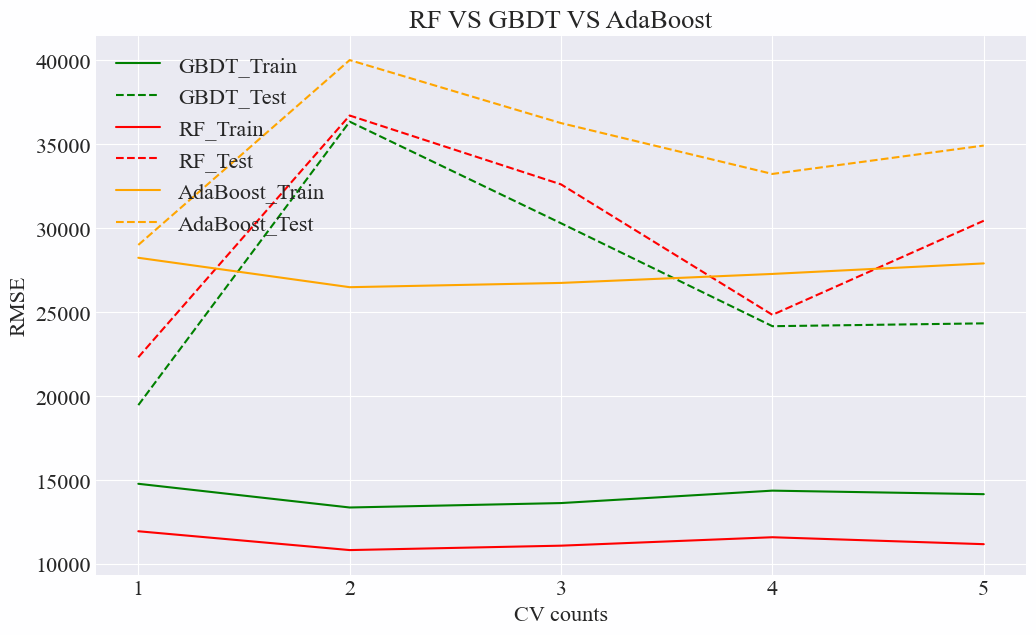

In [10]:
modelname = [ 'GBDT', 'RF', 'AdaBoost', 'RF-TPE', 'Ada-TPE']
models = [
    GBR(random_state=1210),  # 梯度提升回归树
    RFR(random_state=1210, n_jobs=-1),  # 随机森林回归
    ABR(random_state=1210),  # Adaboost模型
    RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=8,
        random_state=1210, verbose=False,n_jobs=-1),  # 具有特定参数的随机森林模型
    ABR(n_estimators=39, learning_rate=0.94,loss='exponential',
        random_state=1210)  # 具有特定参数的Adaboost模型
]
colors = [ 'green', 'red', 'orange', 'blue', 'black']

plt.figure(figsize=(12,7),dpi=100)
for name,model,color in zip(modelname[:3],models[:3],colors[:3]):
    result = cross_validate(model,X, y, cv=cv,
                            scoring="neg_root_mean_squared_error",
                            return_train_score=True,verbose=False,n_jobs=-1)
    plt.plot(range(1,6), abs(result['train_score']),color=color,label=f"{name}_Train")
    plt.plot(range(1,6), abs(result['test_score']),color=color,label=f"{name}_Test",linestyle='--')
plt.xticks([1,2,3,4,5])
plt.xlabel("CV counts")
plt.ylabel("RMSE")
plt.title("RF VS GBDT VS AdaBoost")
plt.legend()
plt.show()

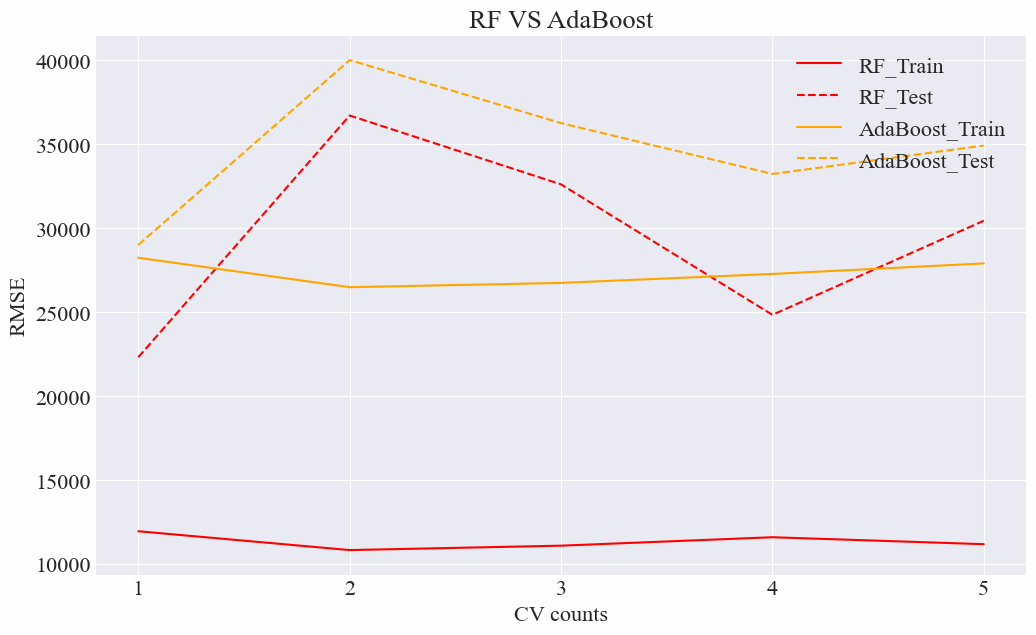

In [11]:
colors = [ 'green', 'red', 'orange', 'blue', 'black']
plt.figure(figsize=(12,7),dpi=100)
for name,model,color in zip(modelname[1:3],models[1:3],colors[1:3]):
    result = cross_validate(model,X, y, cv=cv,
                            scoring="neg_root_mean_squared_error",
                            return_train_score=True,verbose=False,n_jobs=-1)
    plt.plot(range(1,6), abs(result['train_score']),color=color,label=f"{name}_Train")
    plt.plot(range(1,6), abs(result['test_score']),color=color,label=f"{name}_Test",linestyle='--')
plt.xticks([1,2,3,4,5])
plt.xlabel("CV counts")
plt.ylabel("RMSE")
plt.title("RF VS AdaBoost")
plt.legend()
plt.show()

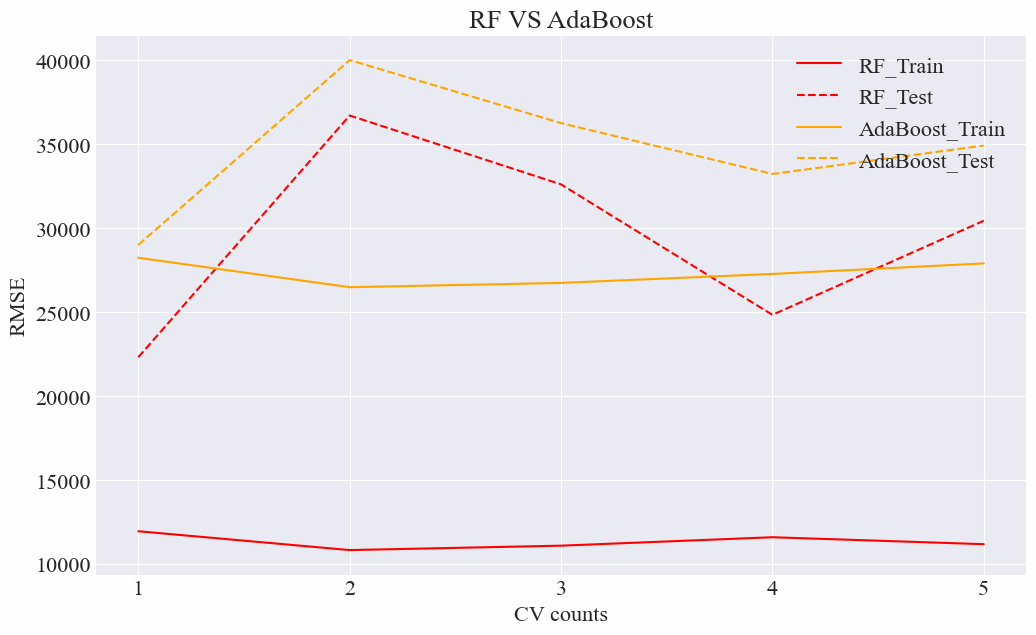

In [12]:
colors = [ 'green', 'red', 'orange', 'blue', 'black']
plt.figure(figsize=(12,7),dpi=100)
for name,model,color in zip(modelname[1:3],models[1:3],colors[1:3]):
    result = cross_validate(model,X, y, cv=cv,
                            scoring="neg_root_mean_squared_error",
                            return_train_score=True,verbose=False,n_jobs=-1)
    plt.plot(range(1,6), abs(result['train_score']),color=color,label=f"{name}_Train")
    plt.plot(range(1,6), abs(result['test_score']),color=color,label=f"{name}_Test",linestyle='--')
plt.xticks([1,2,3,4,5])
plt.xlabel("CV counts")
plt.ylabel("RMSE")
plt.title("RF VS AdaBoost")
plt.legend()
plt.show()

In [14]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns

data['销售状态'].unique()

y = data.iloc[:,-2]
X = data.drop(['SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=1210, stratify=y)

gbc_clf = GBC(random_state=1210)
cv = KFold(n_splits=5, shuffle=True, random_state=1210)
result_clf = cross_validate(gbc_clf, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"*交叉验证后 得分为:  {result_clf['test_score'].mean():.3f}")

*交叉验证后 得分为:  0.848


In [6]:
data['销售状态'].unique()

array([4., 0., 5., 1., 2., 3.])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         4
         4.0       1.00      1.00      1.00       240
         5.0       1.00      1.00      1.00        25

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292



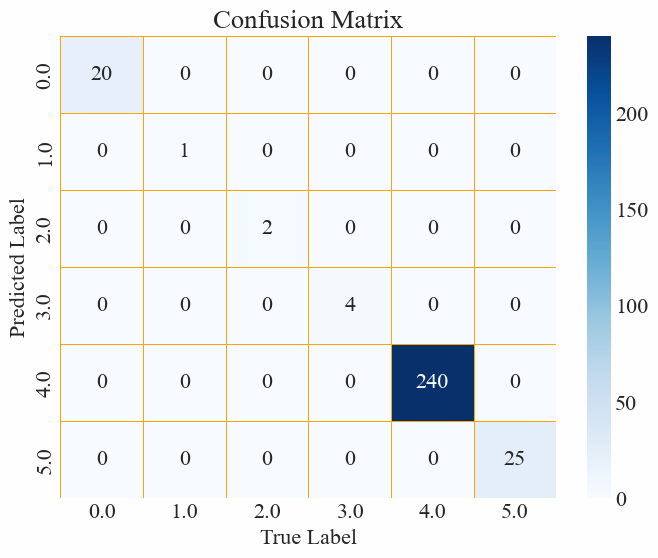

In [15]:
gbc_clf.fit(X_train,y_train)
y_pred = gbc_clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test),
            edgecolor='orange',linewidths=0.4,linecolor='orange')
plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

In [5]:
#使用随机森林回归,以及Adaboost完成回归任务
from sklearn.tree import  DecisionTreeRegressor as DTR
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [10]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [20]:
tree_reg = DTR(random_state=1210)
#初始化上述随机森林
rfr = RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0,
        random_state=1210, verbose=False,n_jobs=-1) # 具有特定参数的随机森林模型
lists = [tree_reg,rfr,'zero',None]

In [21]:

for init in lists:
    reg = GBR(init=init,random_state=1210)#梯度提升算法，采用不用的出事学习器
    cv = KFold(n_splits=5,shuffle=True,random_state=1210)
    result_gbdt = cross_validate(reg,X,y,cv=cv,scoring='neg_root_mean_squared_error',
                                 return_train_score=True,
                                 n_jobs=-1)
    print(f"训练集的MASE为：{np.abs(result_gbdt['train_score'].mean()):.3f}")
    print(f"测试集的MASE为：{np.abs(result_gbdt['test_score'].mean()):.3f}")

训练集的MASE为：0.000
测试集的MASE为：41653.557
训练集的MASE为：5529.944
测试集的MASE为：27430.270
训练集的MASE为：14073.457
测试集的MASE为：27362.346
训练集的MASE为：14073.456
测试集的MASE为：26931.362


In [22]:
reg = GBR(init=None,random_state=1210)
reg.fit(X,y)
reg.init_

DummyRegressor()

In [24]:
reg = GBR(init=rfr,random_state=1210)
reg.fit(X,y)
reg.init_

RandomForestRegressor(max_depth=22, max_features=14, min_impurity_decrease=0,
                      n_estimators=89, n_jobs=-1, random_state=1210,
                      verbose=False)

In [26]:
print(reg.init_)

RandomForestRegressor(max_depth=22, max_features=14, min_impurity_decrease=0,
                      n_estimators=89, n_jobs=-1, random_state=1210,
                      verbose=False)


In [27]:
#分类
y_clf = data.iloc[:,-2]
X_clf = data.drop(['SalePrice'], axis=1)

In [37]:
from time import  time

In [41]:
#迭代提前停止与迭代不提前停止
from sklearn.ensemble import GradientBoostingRegressor as GBR
start_time = time()
gbr = GBR(n_estimators=1000,
          validation_fraction=0.1,#使用10%的数据作为验证集
          random_state=1210,
          n_iter_no_change=3,#连续3次迭代没有改进，则提前停止
          tol=0.01,
          )
gbr.fit(X,y)
end_time = time() - start_time

In [42]:
#不会迭代停止的模型
start_time1 = time()
gbr1 = GBR(n_estimators=1000,
           random_state=1210,
           )
gbr1.fit(X,y)
end_time1 = time() - start_time1

In [43]:
print(f"设置早停机制的实际迭代次数：{gbr.n_estimators_}")
print(f"没设置早停机制的实际迭代次数：{gbr1.n_estimators_}")

设置早停机制的实际迭代次数：83
没设置早停机制的实际迭代次数：1000


In [44]:
print(f"设置早停机制的分数为:{gbr.score(X,y)}")
print(f"没设置早停机制的分数为:{gbr1.score(X,y)}")

设置早停机制的分数为:0.9584643022581825
没设置早停机制的分数为:0.9981679504031234


In [45]:
print(f"设置早停机制的时间为：{end_time}")
print(f"没设置早停机制的时间为：{end_time1}")

设置早停机制的时间为：0.491192102432251
没设置早停机制的时间为：6.4536004066467285
